In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import Normalizer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPooling1D
from keras import callbacks
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import h5py
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading data

#### header = none ,indicates there is no header
#### header = true, indicates there is header and will remove the header(by default this exist) 

In [2]:
path='Datas'

train = pd.read_csv(os.path.join(path,'mitbih_train.csv'),header=None) 
test = pd.read_csv(os.path.join(path,'mitbih_test.csv'),header=None)

x_train= train.iloc[:,0:187]
y_train= train.iloc[:,187]

x_test= test.iloc[:,0:187]
y_test= test.iloc[:,187]

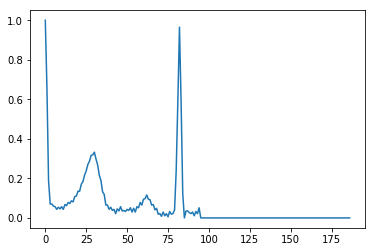

In [3]:
plt.plot(x_train.iloc[2,0:187])
plt.show()


### Here for the same person we are dividing the complete ECG signal into different frames of 1ms and check whether that window is normal or abnormal

#### but same person may have different types of abnormalities


### so this is just like a helping tool for doctors, where if a particular patient hads the no. of abnormalities for each window count more , then he should visit the doctor




In [33]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalizing the data to same range (0,1)

In [4]:
scaler1= Normalizer().fit(x_train)
x_train = scaler1.transform(x_train)

scaler2= Normalizer().fit(x_test)
x_test = scaler2.transform(x_test)

In [5]:
print(x_train.shape)
print(x_test.shape)

(87554, 187)
(21892, 187)


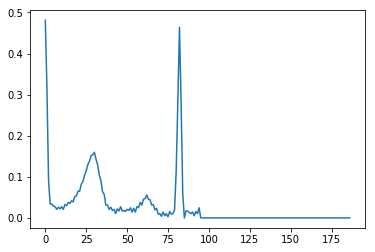

In [6]:
plt.plot(x_train[2,0:187])
plt.show()

### since keras accepts data only in the form of 3 dimensions, we need to reshape the data

In [7]:
x_train=np.array(x_train)
x_test=np.array(x_test)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_train.shape

(87554, 187, 1)

### Converting label to one hot representation

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(87554, 5)

### Creating the CNN Model

In [12]:
model=Sequential()
model.add(Convolution1D(64,3,border_mode='same',activation='relu',input_shape=(187,1)))
model.add(MaxPooling1D(pool_length=(2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))  # to reduce overfitting, some neuron connections will be cut out
model.add(Dense(5,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 187, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 93, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5952)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               761984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 762,885
Trainable params: 762,885
Non-trainable params: 0
_________________________________________________________________


C:\Users\Vyshnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", input_shape=(187, 1), padding="same")`
  
C:\Users\Vyshnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### saving the weights

* callbacks.ModelCheckpoint() defines the function for taking any reports/data from the trained model.
* csvlogger will help to save the report as csv file (accuracy,presicion,recall,f1-score).
* save_best_only=True , monitor='loss'(this will monitor the loss and save the model weights only if the loss has improved and if improved for a several epochs, it will save only the best loss reduction)

Then this fuction is called from the model.fit() and finally saving the model


we can save the model as well as model weights


Even from the model checkpoint saved, we can get the model summary and model weights

In [14]:
checkpointer = callbacks.ModelCheckpoint(filepath='results/checkpoint-{epoch:02d}.hdf5', verbose=1, save_best_only=True, monitor='loss')
csv_logger = CSVLogger('results/cnntrainanalysis1.csv', separator=',', append=False)


model.fit(x_train,y_train, nb_epoch=10, callbacks=[checkpointer,csv_logger])
model.save('results/model1.hdf5')

C:\Users\Vyshnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/10
87554/87554 [==============================] - 118s 1ms/step - loss: 0.2740 - acc: 0.9213

Epoch 00001: loss improved from inf to 0.27401, saving model to results/checkpoint-01.hdf5
Epoch 2/10
87554/87554 [==============================] - 115s 1ms/step - loss: 0.1630 - acc: 0.9558

Epoch 00002: loss improved from 0.27401 to 0.16305, saving model to results/checkpoint-02.hdf5
Epoch 3/10
87554/87554 [==============================] - 115s 1ms/step - loss: 0.1376 - acc: 0.9616

Epoch 00003: loss improved from 0.16305 to 0.13756, saving model to results/checkpoint-03.hdf5
Epoch 4/10
87554/87554 [==============================] - 105s 1ms/step - loss: 0.1212 - acc: 0.9663

Epoch 00004: loss improved from 0.13756 to 0.12122, saving model to results/checkpoint-04.hdf5
Epoch 5/10
87554/87554 [==============================] - 148s 2ms/step - loss: 0.1099 - acc: 0.9695

Epoch 00005: loss improved from 0.12122 to 0.10995, saving model to results/checkpoint-05.hdf5
Epoch 6/10
87554/87

### Transfer Learning 

By using the weights previously trained by some epochs

In [15]:
model.load_weights('results/checkpoint-10.hdf5')

In [16]:
y_pred = model.predict_classes(x_test)

np.savetxt('results/expected.txt',y_test, fmt='%01d')
np.savetxt('results/predicted.txt', y_pred, fmt='%01d')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss, accuracy= model.evaluate(x_test,y_test)

print('\nLoss: %.2f, Accuracy: %.2f%%' %(loss,accuracy*100) )

21892/21892 [==============================] - 6s 288us/step

Loss: 0.09, Accuracy: 97.50%


### Metrics

In [17]:
import sklearn.metrics 

y_expected=test.iloc[:,187]

Acuuracy=sklearn.metrics.accuracy_score(y_expected,y_pred)
precision=sklearn.metrics.precision_score(y_expected,y_pred, average=None)
recall=sklearn.metrics.recall_score(y_expected,y_pred, average=None)
f1=sklearn.metrics.f1_score(y_expected,y_pred, average=None)


print('Acuuracy=',accuracy)
print('precision=',precision)
print('Recall=',recall)
print('f1_score=',f1)

Acuuracy= 0.97496802484926
precision= [0.97830803 0.92513369 0.9534712  0.76865672 0.9836478 ]
Recall= [0.99569489 0.62230216 0.89157459 0.63580247 0.97263682]
f1_score= [0.98692489 0.74408602 0.92148465 0.69594595 0.97811132]


In [26]:
# y_expected=test.iloc[:,187]

# sklearn.metrics.accuracy_score(y_expected,y_pred)
# precision=sklearn.metrics.precision_score(y_expected,y_pred, average=None)
# recall=sklearn.metrics.recall_score(y_expected,y_pred, average=None)
# f1_score=sklearn.metrics.f1_score(y_expected,y_pred, average=None)
# confusion=confusion_matrix(y_expected,y_pred)
# confusion=pd.DataFrame(confusion)


# print('Acuuracy=',accuracy)
# print('precision=',accuracy)
# print('Recall=',accuracy)
# print('f1_score=',accuracy)


In [18]:
import scipy

scipy.io.savemat('y_test.mat',y_expected)
scipy.io.savemat('y_pred.mat',y_pred)


TypeError: 'int' object is not subscriptable

Confusion matrix, without normalization
[[18014    20    57     3    24]
 [  193   349    12     0     2]
 [   68     3  1367     4     6]
 [   51     0    30    81     0]
 [   32     0     8     0  1568]]
onfusion matrix
[[9.94e-01 1.10e-03 3.15e-03 1.66e-04 1.32e-03]
 [3.47e-01 6.28e-01 2.16e-02 0.00e+00 3.60e-03]
 [4.70e-02 2.07e-03 9.44e-01 2.76e-03 4.14e-03]
 [3.15e-01 0.00e+00 1.85e-01 5.00e-01 0.00e+00]
 [1.99e-02 0.00e+00 4.98e-03 0.00e+00 9.75e-01]]


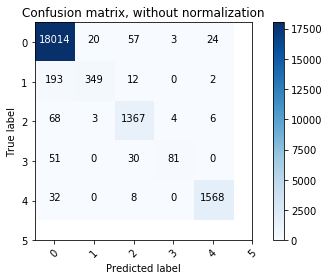

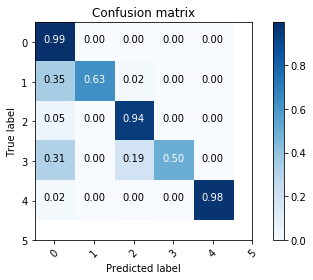

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
class_names=['0','1','2','3','4','5']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("onfusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_expected, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')

plt.show()  

In [15]:
from sklearn.metrics import classification_report
sklearn.metrics.classification_report(y_expected, y_pred)
target_names = ['normal', 'abnormal1', 'abnormal2', 'abnormal3', 'abnormal4']
print(classification_report(y_expected, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.98      0.99      0.99     18118
   abnormal1       0.94      0.63      0.75       556
   abnormal2       0.93      0.94      0.94      1448
   abnormal3       0.92      0.50      0.65       162
   abnormal4       0.98      0.98      0.98      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.95      0.81      0.86     21892
weighted avg       0.98      0.98      0.98     21892



In [5]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_expected,y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)


In [6]:
# plt.title('Receiver Operating Characteristic')
# plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.2])
# plt.ylim([-0.1,1.2])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()